Neural networks are a good tool for both classification because they can automatically perform a non-linear change of basis on the data that is optimal for prediction.  They also have the capacity to give us some really useful insights into how they work and why they're so good at generalizing.  Here, we'll construct one from scratch in numpy, in particular one that will solve the binary classification problem.

In [4]:
from __future__ import division,print_function

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']= (16,9)

We'll be generating initial guesses, etc. using random numbers.  To ensure that things go according to plan, let's seed the numpy pseudorandom number generator

In [5]:
np.random.seed(0)

Now let's make some data to classify.  We can choose any function, but if we want to challenge this thing, it should be something that would fail under normal logistic regression.  For example, let's generate some data that is Bernoulli distributed with $\theta(x)$ given by two independent bell curves.   I'll generate data from this distribution using a variant of [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling).

In [35]:
classes = [0,1]

m = 100
x = np.random.rand(m)
x.sort()
y_pdf = np.exp(-((x-0.25)/0.1)**2) + np.exp(-((x-0.75)/0.1)**2)
y_pdf /= y_pdf.max()
a = np.random.rand(m)
y = (a<=y_pdf).astype(int)


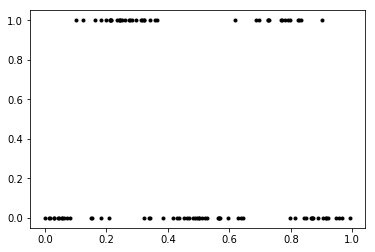

In [36]:
plt.plot(x,y,'k.')
plt.show()

Not only this data not linearly-seperable, it is also multimodal:  Naive Bayes would be bound to fail because we could not *a priori* determine a sensible probability model for the data.  Logistic regression with the linear basis would also be bound to fail because it can't deal with multiple peaks like this (although we could enrich the basis set instead).  A neural network will allow us to *learn* good basis functions, or how to transform the data to optimize classification.    

I confess that I have not implemented a binary classifier: it seemed like a waste of effort when a multiclass method will work fine for the two class case!  As such, we need to make the $T$ matrix (the one hot representation of our class labels).

In [37]:
m = x.shape[0]
N = len(classes)

T = np.zeros((m,N))
for t,yi in zip(T,y):
    t[yi]=1
    
print(T[::10])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


Now we can import the neural network that I've coded, (the skeleton of) which is available on the course moodle.  

In [38]:
from neural_network import Network

We can build a neural network for our problem with the following syntax:

In [45]:
nn = Network([1,4,2],[None,'sigmoid','softmax'],[True,True,False],layer_weight_means_and_stds=[(0,0.1),(0,0.1)],)

The first argument is the number of nodes in each layer, so we have one input layer with one node, one hidden layer with four nodes, and one output layer with two nodes.  

The second argument is the activation function associated with each.  The input layer has no activation, the second layer is sigmoids, and the third layer is softmax.  

The third argument is a boolean value, which states whether to append a bias node for each layer.

layer_weight_means_and_stds gives the statistics of the initial guess for weights.

We can make predictions with the nn.feed_forward function.  Before we train, we can verify that this, and our gradient code is working properly by computing a finite difference.

In [46]:
nn.feed_forward(x)
J0 = nn._J_fun(x,T)
eps = 1e-5

nn.weights[1][1,1] += eps
nn.feed_forward(x)
J1 = nn._J_fun(x,T)
print('Gradient code: ',nn._gradient_fun(x,T)[1][1,1], ', Finite difference:',(J1-J0)/eps)

Gradient code:  -0.36476213345820685 , Finite difference: -0.3647623117331022


These are the same to within 6 places, so good enough.

Now, we are all set to perform gradient descent.  We need to define a learning rate $\eta$:

In [47]:
eta = 0.01

Then we iterate for as long as we want.  We'll allow 100000 iterations on the full data.

In [48]:
cost_function_values = []
N_iters = 100000

for _ in range(N_iters):
    nn.feed_forward(x)
    cost_function_values.append(nn._J_fun(x,T))
    grad_w = nn._gradient_fun(x,T)
    for w,gw in zip(nn.weights,grad_w):
        w -= eta*gw

This takes a minute to train.  When it's finished, we can plot the results:

Accuracy:  0.83


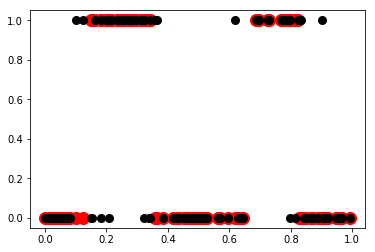

In [50]:
y_pred = np.argmax(nn.feed_forward(x),axis=1)
print ('Accuracy: ',1-sum(y_pred!=y.ravel())/float(len(y)))

plt.plot(x,y_pred,'ro',markersize=12)
plt.plot(x,y,'ko',markersize=8)
plt.show()


Pretty good results for a problem that would have thwarted one of our earlier classifiers.  Let's examine what this thing is doing a little bit more deeply.  It's particularly interesting to look at the outputs of the hidden layer, or what basis functions the model decided to transform the data to before classification. 

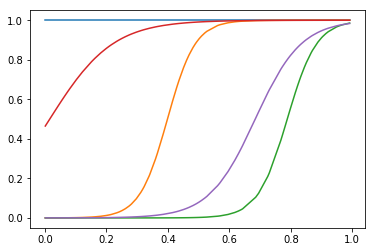

In [59]:
#plt.plot(x,y_pred,'ro',markersize=12)
#plt.plot(x,y,'ko',markersize=8)

#plt.plot(x,np.ones_like(x),'r--')
#plt.plot(x,x,'b--')

#for k in range(4):
plt.plot(x,nn.z_vals[1],'-')
    
plt.show()

In [57]:
nn.z_vals[1]

array([[1.00000000e+00, 1.57529486e-04, 7.15611527e-08, 4.64810900e-01,
        1.09361678e-04],
       [1.00000000e+00, 2.10773366e-04, 9.43332335e-08, 4.96981526e-01,
        1.30470444e-04],
       [1.00000000e+00, 2.17244222e-04, 9.70791702e-08, 5.00328629e-01,
        1.32883863e-04],
       [1.00000000e+00, 2.88887151e-04, 1.27228482e-07, 5.31835045e-01,
        1.57943495e-04],
       [1.00000000e+00, 2.99600430e-04, 1.31701745e-07, 5.35847518e-01,
        1.61468507e-04],
       [1.00000000e+00, 3.93115519e-04, 1.70433245e-07, 5.65602191e-01,
        1.90372737e-04],
       [1.00000000e+00, 4.14972263e-04, 1.79414054e-07, 5.71479951e-01,
        1.96720733e-04],
       [1.00000000e+00, 5.18489853e-04, 2.21644772e-07, 5.95445564e-01,
        2.25157573e-04],
       [1.00000000e+00, 5.32503145e-04, 2.27326941e-07, 5.98287581e-01,
        2.28827550e-04],
       [1.00000000e+00, 6.13101265e-04, 2.59868379e-07, 6.13194675e-01,
        2.49240903e-04],
       [1.00000000e+00, 7.7074

These basis functions represent a transform of our data to a new four dimensional space.  It's instructive to see what we get when we add them up and scale them by some weights that we found with gradient descent: the inputs $a_1^{(2)}$ and $a_2^{(2)}$ to the final layer).

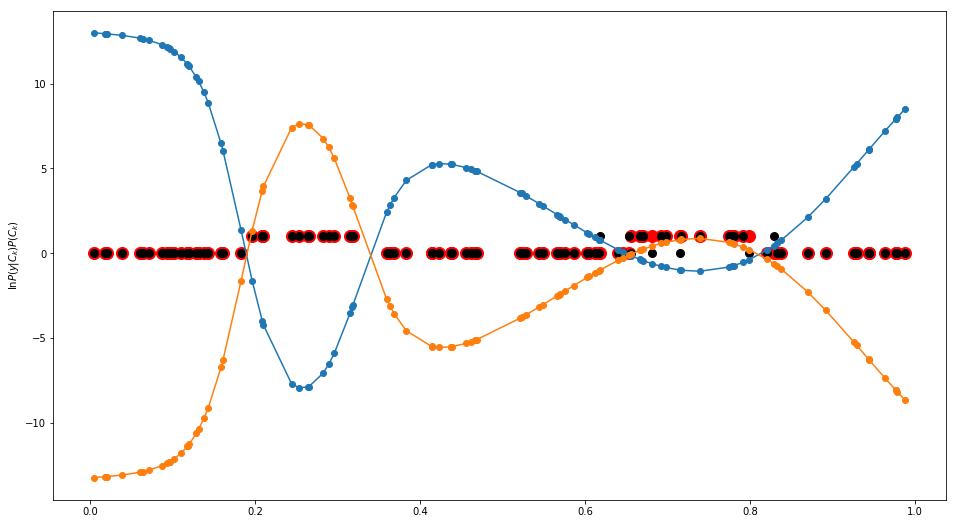

In [41]:
plt.plot(x,y_pred,'ro',markersize=12)
plt.plot(x,y,'ko',markersize=8)
plt.plot(x,nn.a_vals[2][:,0],'o-')
plt.plot(x,nn.a_vals[2][:,1],'o-')
plt.ylabel('$\ln P(y|C_k) P(C_k)$')
    
plt.show()

In [47]:
print(nn.weights[2])

[[ -0.99558385   0.93394398]
 [ 11.44940082 -11.59636557]
 [  4.5889155   -4.37900986]
 [ -0.41330502   0.43716106]
 [ -1.12881316   1.0846375 ]
 [-18.53583592  18.49477315]
 [  7.89407789  -8.09936316]
 [ -4.2369812    4.10648558]
 [ 10.03251408  -9.93496009]
 [ 22.26933383 -22.20782147]
 [ -1.07735755   0.88716605]]


Recall that the input to the softmax function is log-probabilities.  That's still what these curves represent.  In particular, you can see that the decision boundaries occur where the log-probabilities for each class are equal.

Finally, it's interesting to look at the evolution of the cost function through gradient descent.

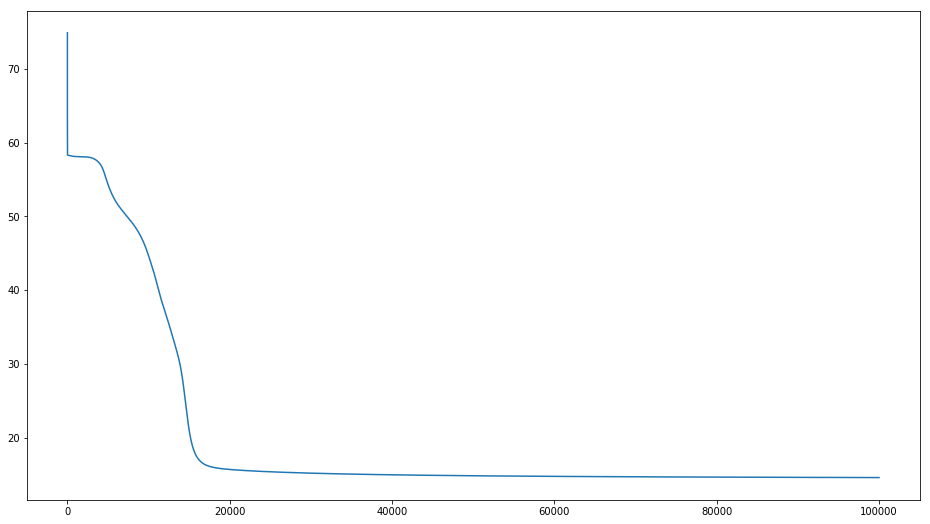

In [42]:
plt.plot(cost_function_values)
plt.show()

Of course, we can also apply this classification system to harder problems.  For example, we could easily apply the exact same procedure to the iris dataset.

In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
iris = datasets.load_iris()
X = iris.data
y = iris.target
X,X_test,y,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

classes = [0,1,2]

m = X.shape[0]
n = X.shape[1]
N = len(classes)

T = np.zeros((m,N))
for t,yi in zip(T,y):
    t[yi]=1

This time, our neural network will have four input nodes, and 3 output nodes.  However, let's include some more hidden nodes, just to give our model plenty of flexibility.

In [30]:
np.random.seed(13)
nn = Network([4,20,3],[None,'sigmoid','softmax'],[True,True,False],layer_weight_means_and_stds=[(0,10.),(0,10.0)])

Then it's just a matter of training exactly as before.

In [31]:
cost_function_values = []
N_iters = 20000

eta = 0.001

for _ in range(N_iters):
    nn.feed_forward(X)
    cost_function_values.append(nn._J_fun(X,T))
    grad_w = nn._gradient_fun(X,T)
    for w,gw in zip(nn.weights,grad_w):
        w -= eta*gw

Now we can evaluate the accuracy.

0.99
0.98


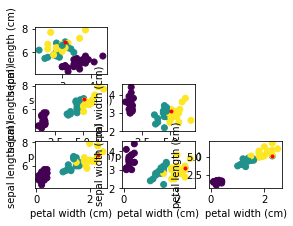

In [32]:
y_pred = np.argmax(nn.feed_forward(X),axis=1)
print(1-sum(y_pred!=y)/float(len(y)))

y_pred_test = np.argmax(nn.feed_forward(X_test),axis=1)
print(1-sum(y_pred_test!=y_test)/float(len(y_test)))

fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X_test[:,i],X_test[:,j],c=y_pred_test)
            axs[i,j].plot(X_test[y_test!=y_pred_test,i],X_test[y_test!=y_pred_test,j],'ro',markersize=3)
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.show()

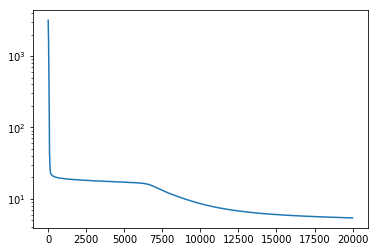

In [33]:
plt.semilogy(cost_function_values)
plt.show()